In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.utils import resample

In [2]:
df = pd.read_csv(r"../data/modeling_data.csv.zip", compression="zip")

In [3]:
df.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,...,Color_3,Color_4,Color_5,Color_6,Color_7,NoNameFlag,BreedType,VideoAmt,PhotoAmt,Description_count
0,2,3,299,0,1,1,7,0,1,1,...,0,0,0,0,1,0,3,0,1.0,359
1,2,1,265,0,1,1,2,0,2,2,...,0,0,0,0,0,1,1,0,2.0,118
2,1,1,307,0,1,2,7,0,2,2,...,0,0,0,0,1,0,0,0,7.0,393
3,1,4,307,0,2,1,2,0,2,1,...,0,0,0,0,0,0,0,0,8.0,146
4,1,1,307,0,1,1,0,0,2,1,...,0,0,0,0,0,0,0,0,3.0,390


In [4]:
df['AdoptionSpeed'].value_counts()

3    4197
1    4037
0    3500
2    3259
Name: AdoptionSpeed, dtype: int64

In [5]:
def downsample(speed, size=df['AdoptionSpeed'].value_counts().min()):
    return resample(df[df['AdoptionSpeed']==speed], replace=False, n_samples=size, random_state=11)

ds = pd.concat([downsample(0), downsample(1), downsample(2), downsample(3)])
ds['AdoptionSpeed'].value_counts()

3    3259
2    3259
1    3259
0    3259
Name: AdoptionSpeed, dtype: int64

In [6]:
X_train, X_val, y_train, y_val = train_test_split(ds.drop(['AdoptionSpeed'], axis=1), ds[['AdoptionSpeed']], 
                                                    stratify = ds['AdoptionSpeed'], test_size=0.3, random_state=12)

In [7]:
print(len(X_train))
print(len(X_val))

9125
3911


In [8]:
m_xgb = XGBClassifier(max_depth=5,
                      min_child_weight=5,
                      subsample=0.8,
                      colsample_bytree=0.8,
                      learning_rate = 0.1,
                      reg_alpha = 0, reg_lambda = 0, gamma=0,
                      objective= "multi:softprob",
                      random_state=123,
                      n_jobs=-1, n_estimators = 999,
                     use_label_encoder=False)

m_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
          eval_metric='mlogloss', early_stopping_rounds=10, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=999, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=123, reg_alpha=0,
              reg_lambda=0, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [9]:
pred_prob = m_xgb.predict_proba(X_val)
pred = m_xgb.predict(X_val)

In [10]:
pred_prob

array([[0.19222823, 0.23407035, 0.45238984, 0.12131155],
       [0.39888522, 0.27884042, 0.27621284, 0.04606155],
       [0.2806434 , 0.29110613, 0.25499794, 0.17325252],
       ...,
       [0.13150616, 0.2575999 , 0.5207008 , 0.09019314],
       [0.4221544 , 0.2738125 , 0.22120832, 0.08282474],
       [0.14836039, 0.16730742, 0.46847558, 0.21585658]], dtype=float32)

In [11]:
pred

array([2, 0, 1, ..., 2, 0, 2])

In [12]:
np.array(np.unique(pred, return_counts=True)).T

array([[   0, 1197],
       [   1,  758],
       [   2,  744],
       [   3, 1212]])

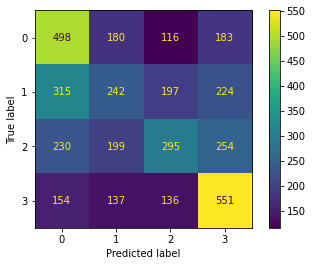

In [13]:
plot_confusion_matrix(m_xgb, X_val, y_val);

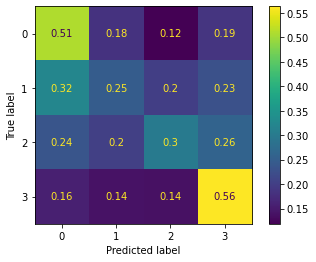

In [14]:
plot_confusion_matrix(m_xgb, X_val, y_val, normalize='true');

In [15]:
def get_error(actual, pred):
    cm = confusion_matrix(actual, pred, normalize='true')
    return cm[0][1:].sum() + cm[1][2:].sum() + cm[2][3:]

In [16]:
get_error(y_val, pred)

array([1.18046041])